In [2]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sn

# Introduction to Machine Learning: Supervised Learning

## Introduction and Problem Description

Welcome to my final project for DTSA-5509! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed above. Also if you intend to run this notebook, ensure to place the folder extracted from the data source called "Rice_Images_Dataset" containing the image data into a fresh directory called "data", and set your local directory to contain "data". As a note, the dataset is reasonably large (~1 GB), so download may take a while. Thanks for taking the time to grade my work!

For this project I wanted to do machine learning models on fantasy football data. 

I'll use three different ML models that we learned in this course:

A KNN Classifier

A Random Forest Classifier

A ADA Boost Classifier

In [3]:
weekly_nfl = nfl.import_weekly_data(years=[2023])
#print(weekly_nfl.columns)

Downcasting floats.


In [4]:
# Filter the data for Wide Receivers (WR)

wr_data = weekly_nfl[weekly_nfl['position'] == 'WR']

# Sort the data by 'fantasy_points_ppr' in descending order

sorted_wr_data = wr_data.sort_values(by='fantasy_points_ppr', ascending=False)

df = sorted_wr_data

# Display the first few rows of the sorted data

#print(sorted_wr_data.head())
# Select specific columns to display

columns_to_display = ['player_id', 'player_name', 'player_display_name', 'recent_team' , 'week', 'opponent_team', 'fantasy_points_ppr' , 'target_share' ,'targets', 'receptions', 'receiving_yards', 'receiving_epa', 'rushing_yards']

# Display the sorted data with selected columns
print(sorted_wr_data[columns_to_display].head(5))

# Optionally, adjust pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set display width
pd.set_option('display.max_colwidth', 20)   # Set max column width

       player_id player_name player_display_name recent_team  week  \
3587  00-0036900     J.Chase       Ja'Marr Chase         CIN     5   
443   00-0031544    A.Cooper        Amari Cooper         CLE    16   
1895  00-0034827     D.Moore          D.J. Moore         CHI     5   
163   00-0030279     K.Allen        Keenan Allen         LAC     3   
773   00-0033040      T.Hill         Tyreek Hill         MIA     1   

     opponent_team  fantasy_points_ppr  target_share  targets  receptions  \
3587           ARI           52.200001      0.431818       19          15   
443            HOU           51.500000      0.348837       15          11   
1895           WAS           49.000000      0.400000       10           8   
163            MIN           45.459999      0.416667       20          18   
773            LAC           44.500000      0.340909       15          11   

      receiving_yards  receiving_epa  rushing_yards  
3587            192.0      17.092861            0.0  
443     

In [5]:
#This cell prints the features we will be using in the EDA, along with information about EDAdata. All other features in Rice_MSC_Dataset seem to be statistical calculations, which may not have 
## direct physical meaning (have to do with orientation on image?)

# List of columns to include
columns_to_include = [
    'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 'receptions', 'targets', 'receiving_yards',
    'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
    'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr'
]

# Filter the DataFrame to include only the specified columns
filtered_df = df[columns_to_include]

# Generate and display the summary statistics
summary = filtered_df.describe().round(2)
print("Summary Statistics for Selected Columns:")
display(summary.style.set_table_attributes("style='display:inline'").set_caption("Summary Statistics"))

Summary Statistics for Selected Columns:


<Axes: >

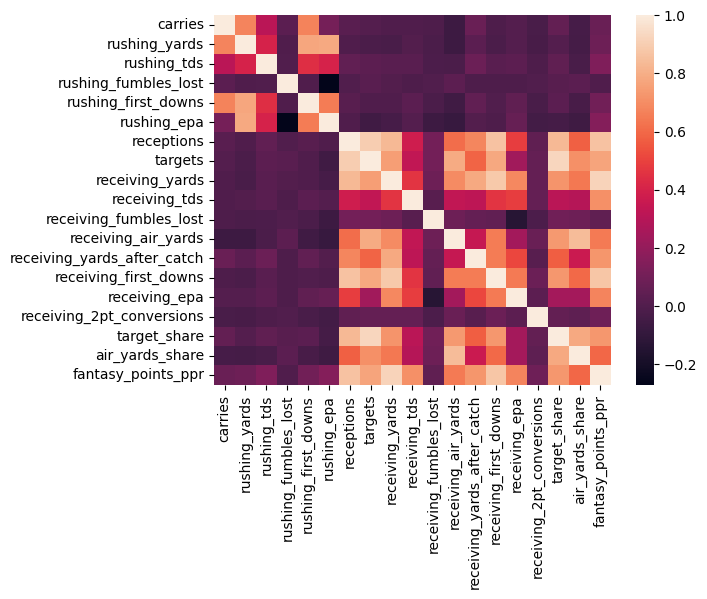

In [6]:
# List of columns you want to include in the cor3relation matrix
columns_to_include = [
    'carries',
    'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'target_share', 'air_yards_share',
    'fantasy_points_ppr'
]

# Select only the columns you want
selected_data = sorted_wr_data[columns_to_include]

# Filter out non-numeric columns
numeric_data = selected_data.select_dtypes(include=['number'])

# Create the correlation matrix
corrMatrix = numeric_data.corr()

sn.heatmap(corrMatrix)


## Matrix Analysis


1.    Strong Positive Correlations:

        - receptions and targets (0.90): This suggests that as the number of receptions increases, the number of targets also tends to increase, which is expected.
        
        - receiving_yards and fantasy_points_ppr (0.91): This indicates that higher receiving yards are strongly associated with higher fantasy points in PPR (points per reception) leagues.
        
        - fantasy_points and fantasy_points_ppr (0.97): This very high correlation is expected since both metrics are closely related, with PPR adding points for receptions.
        
3.    Moderate Positive Correlations:
        
        - rushing_yards and rushing_first_downs (0.78): More rushing yards are associated with more first downs, which makes sense in a football context.
        
        - receiving_yards and receiving_first_downs (0.87): More receiving yards are associated with more first downs.
  
4.    Weak or No Correlations:
        
        - rushing_yards and rushing_first_downs (0.78): More rushing yards are associated with more first downs, which makes sense in a football context.
        
        - rushing_fumbles and most other variables: The correlations are very low, indicating little to no linear relationship with other metrics.

        - special_teams_tds and most other variables: This metric shows very low correlation with others, suggesting it doesn't strongly relate to the other performance metrics.

6.    Negative Correlations:

        - rushing_epa and rushing_fumbles (-0.54): This suggests that more fumbles are associated with a lower expected points added (EPA) from rushing, which is logical as fumbles can negatively impact a team's performance.


## Pair Plot

Pair plot is a fast way to inspect relationships between features. Use seaborn's .pairplot() function to draw a pairplot if the first 10 columns (including price) and inspect their relationships. Set the diagonal elements to be KDE plot. The resulting plot will look like below.

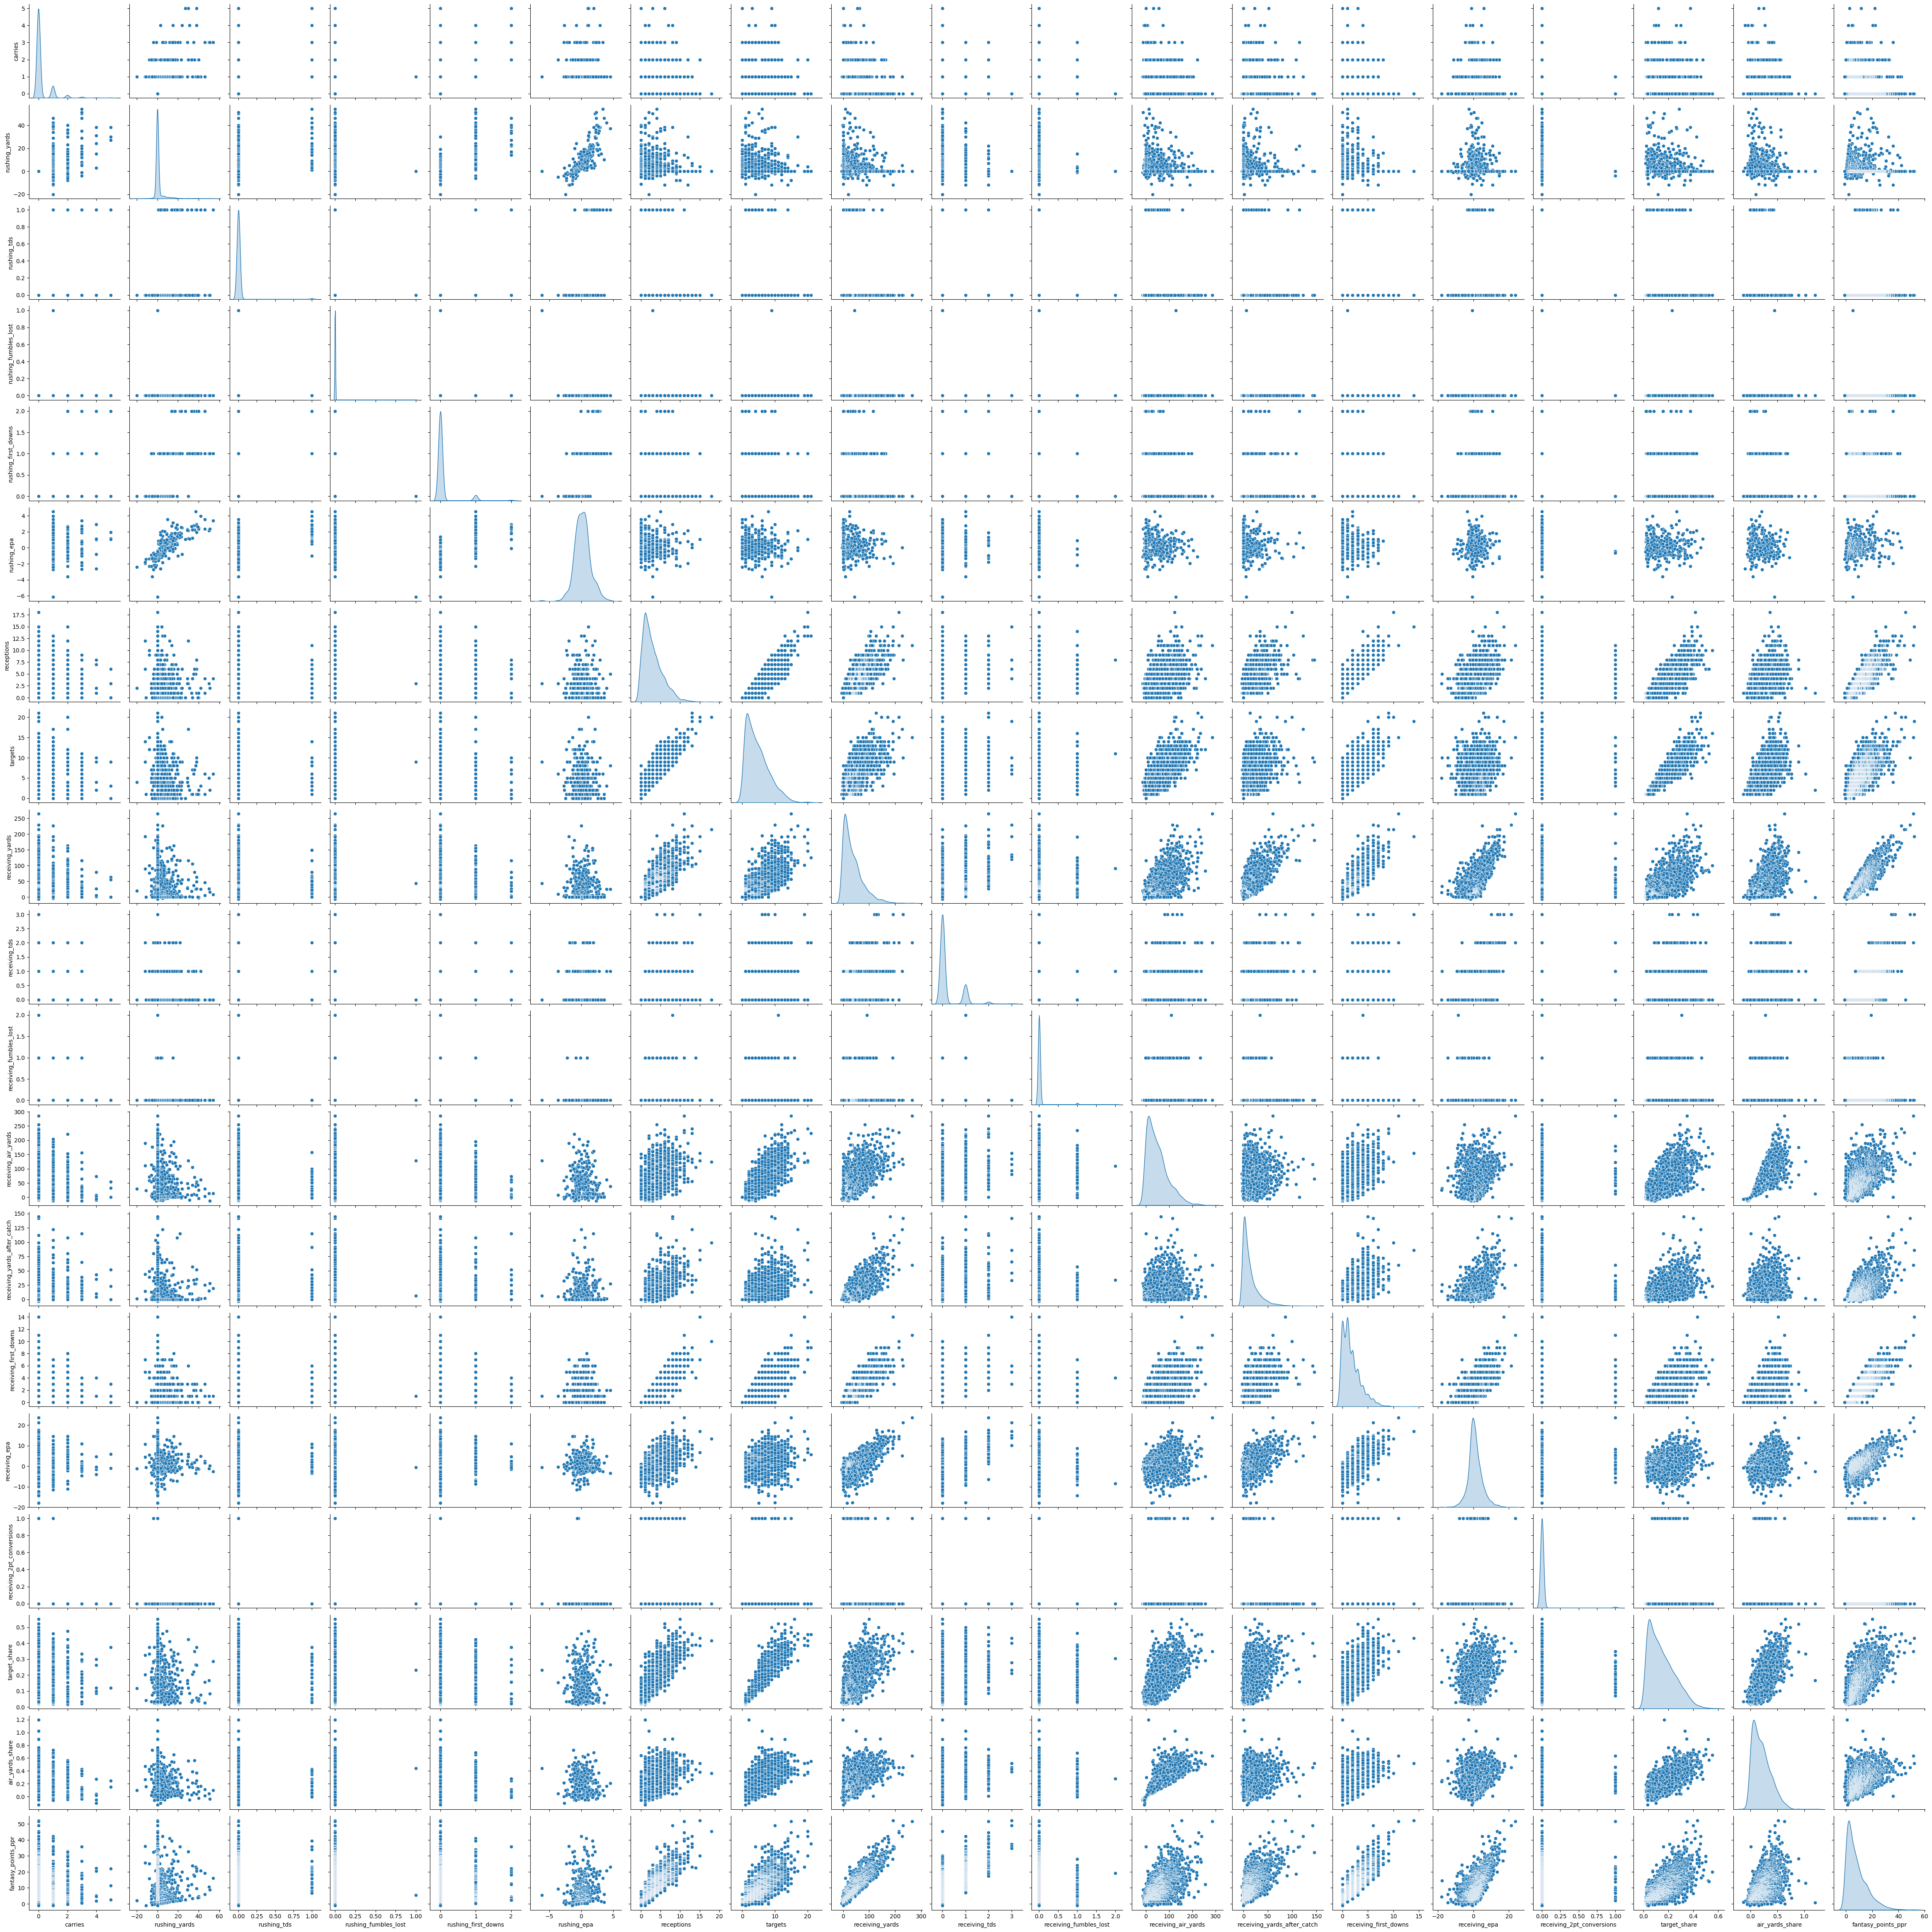

In [7]:
import seaborn as sns

# Create the pair plot
sns.pairplot(df[columns_to_include], diag_kind='kde')

# Show the plot
plt.show()

## Splitting Fantasy Data into Training and Testing Sets

This guide demonstrates how to use the train_test_split function from the sklearn.model_selection module to divide your fantasy data into training and testing subsets. By splitting the data, you can train your machine learning models on one portion and evaluate their performance on another, ensuring a robust assessment of the model's predictive capabilities. The example provided uses an 80/20 split, but you can adjust the test_size parameter to suit your needs.

In [8]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame containing the fantasy data
# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Print the lengths of the training and testing sets
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")

Length of X_train: 1865
Length of X_test: 467


## Train a simple linear regression model

This section demonstrates how to build and train a simple linear regression model using your fantasy data. The process involves splitting the data into training and testing sets, selecting a predictor, and evaluating the model's performance using the adjusted R-squared value.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

# Assuming 'df' is your DataFrame containing the fantasy data
# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Define the best_guess_predictor (for example, let's use 'carries')
best_guess_predictor = 'target_share'

# Build and train the simple linear regression model
model = smf.ols(formula=f'fantasy_points ~ {best_guess_predictor}', data=X_train).fit()

# Print the result summary
print(model.summary())

# Update the adjusted R-squared value according to the result
adj_R2 = model.rsquared_adj
print(f"Adjusted R-squared value: {adj_R2:.4f}")

                            OLS Regression Results                            
Dep. Variable:         fantasy_points   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1197.
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          4.23e-202
Time:                        23:55:52   Log-Likelihood:                -5352.9
No. Observations:                1825   AIC:                         1.071e+04
Df Residuals:                    1823   BIC:                         1.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0127      0.188     -0.067   

## Best Predictor

In the last section we guessed what would be the best predictor, now we are going to test to see what the top 3 predictors actually are 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

# Assuming df is your DataFrame and it's already loaded

# Select a subset of predictors with minimal missing values
selected_predictors = ['carries',
    'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'target_share', 'air_yards_share']

# Impute missing values with the mean for the selected predictors
imputer = SimpleImputer(strategy='mean')
df[selected_predictors] = imputer.fit_transform(df[selected_predictors])

# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Ensure the target variable is numeric
X_train['fantasy_points_ppr'] = pd.to_numeric(X_train['fantasy_points_ppr'], errors='coerce')

# Check if the dataset is empty after imputing missing values
if X_train.empty:
    print("The dataset is empty after imputing missing values. Please check your data.")
else:
    # Dictionary to store adjusted R-squared values
    adj_r2_values = {}

    # Fit a simple linear regression model for each selected predictor
    for predictor in selected_predictors:
        model = smf.ols(formula=f'fantasy_points_ppr ~ {predictor}', data=X_train).fit()
        adj_r2_values[predictor] = model.rsquared_adj

    # Convert the dictionary to a DataFrame for easier sorting
    adj_r2_df = pd.DataFrame(list(adj_r2_values.items()), columns=['Predictor', 'Adjusted R-squared'])

    # Sort the DataFrame by adjusted R-squared values in descending order
    adj_r2_df = adj_r2_df.sort_values(by='Adjusted R-squared', ascending=False)

    # Print the ranked list of all predictors
    print("Ranked list of selected predictors based on adjusted R-squared values:")
    print(adj_r2_df)

    # Print the top three predictors
    top_three_predictors = adj_r2_df.head(5)
    print("\nTop three predictors in order:")
    print(top_three_predictors)

    # Update the top_three list
    top_three = top_three_predictors['Predictor'].tolist()
    print("\nTop three predictors list:")
    print(top_three)

Ranked list of selected predictors based on adjusted R-squared values:
              Predictor  Adjusted R-squared
8       receiving_yards            0.851402
13  receiving_first_...            0.763862
6            receptions            0.750264
7               targets            0.600553
12  receiving_yards_...            0.530948
16         target_share            0.529301
9         receiving_tds            0.503312
14        receiving_epa            0.441861
11  receiving_air_yards            0.416634
17      air_yards_share            0.340036
2           rushing_tds            0.021139
15  receiving_2pt_co...            0.011426
4   rushing_first_downs            0.010095
5           rushing_epa            0.006621
1         rushing_yards            0.006145
10  receiving_fumble...            0.003912
0               carries            0.003004
3   rushing_fumbles_...           -0.000468

Top three predictors in order:
              Predictor  Adjusted R-squared
8       receiving

## Best Predictor Evaluation

In the "Best Predictor" section, we aimed to identify the top features that most significantly impact the prediction of fantasy points. By fitting simple linear regression models for each selected predictor, we evaluated their effectiveness using the adjusted R-squared value. The top predictors identified were:

   - Receiving Yards: With the highest adjusted R-squared value, this feature is the most significant predictor of fantasy points, indicating that players with higher receiving yards tend to score more fantasy points.
   - Receiving First Downs: This feature also showed a strong correlation with fantasy points, suggesting that players who frequently achieve first downs contribute significantly to their team's success and fantasy scores.
   - Receptions: The number of receptions was another key predictor, highlighting the importance of a player's ability to catch passes in accumulating fantasy points.

These findings underscore the importance of focusing on receiving metrics when evaluating wide receivers for fantasy football.

## Plots

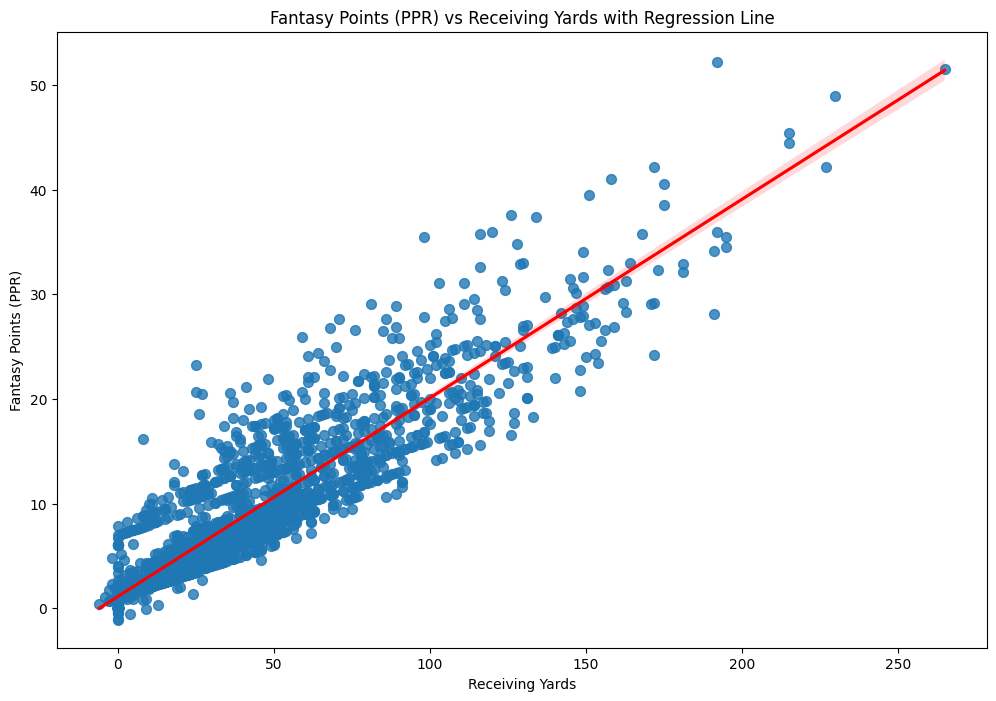

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame

# Plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='receiving_yards', y='fantasy_points_ppr', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Receiving Yards')
plt.ylabel('Fantasy Points (PPR)')
plt.title('Fantasy Points (PPR) vs Receiving Yards with Regression Line')

# Display the plot
plt.show()

## Receiving Yards vs. Fantasy Points:
The regression line in this plot shows a strong positive correlation, confirming that as receiving yards increase, so do the fantasy points. This aligns with our earlier analysis of receiving yards being a top predictor.

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_26044/3151088898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='receiving_first_downs_group', y='fantasy_points_ppr', data=df, palette='Set1')


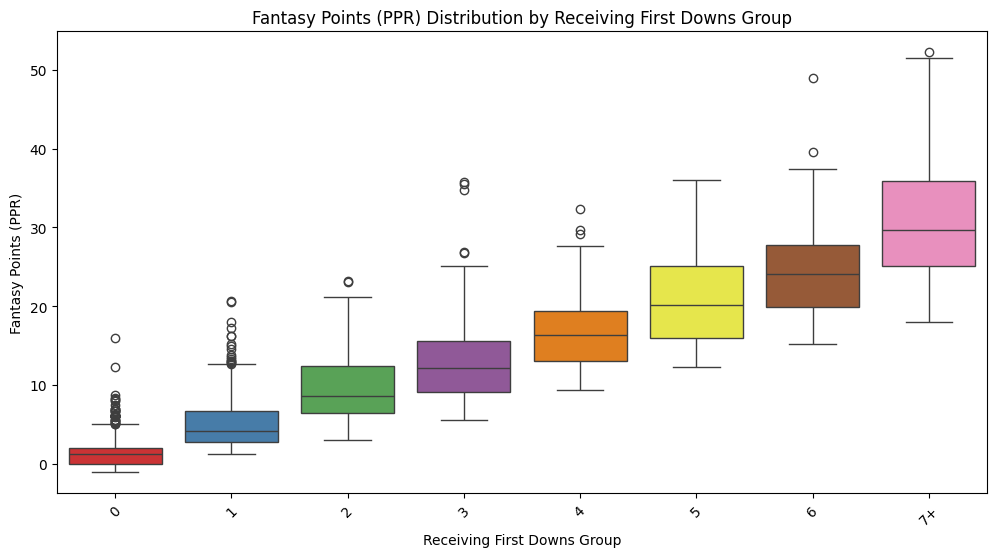

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame

# Create bins for receiving_first_downs
bins = [-1, 0, 1, 2, 3, 4, 5, 6, float('inf')]
labels = ['0', '1', '2', '3', '4', '5', '6', '7+']
df['receiving_first_downs_group'] = pd.cut(df['receiving_first_downs'], bins=bins, labels=labels, right=True)

# Plot the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='receiving_first_downs_group', y='fantasy_points_ppr', data=df, palette='Set1')
plt.title('Fantasy Points (PPR) Distribution by Receiving First Downs Group')
plt.xlabel('Receiving First Downs Group')
plt.ylabel('Fantasy Points (PPR)')
plt.xticks(rotation=45)
plt.show()

## Receiving First Downs Group vs. Fantasy Points: 
The box plot illustrates the distribution of fantasy points across different groups of receiving first downs. Players with more first downs tend to have higher fantasy points, as shown by the upward trend in the box plot.

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_26044/900651058.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='receptions', data=df, palette='Set1')


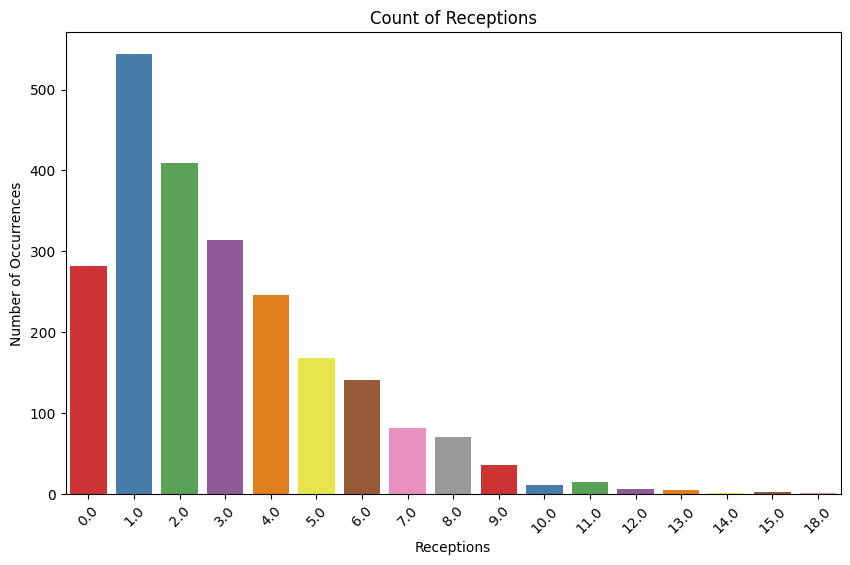

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(x='receptions', data=df, palette='Set1')
plt.title('Count of Receptions')
plt.xlabel('Receptions')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

## Receptions vs. Fantasy Points: 
The count plot of receptions provides insight into the frequency of different reception counts. Players with higher reception counts generally have higher fantasy points, reinforcing the importance of this feature.

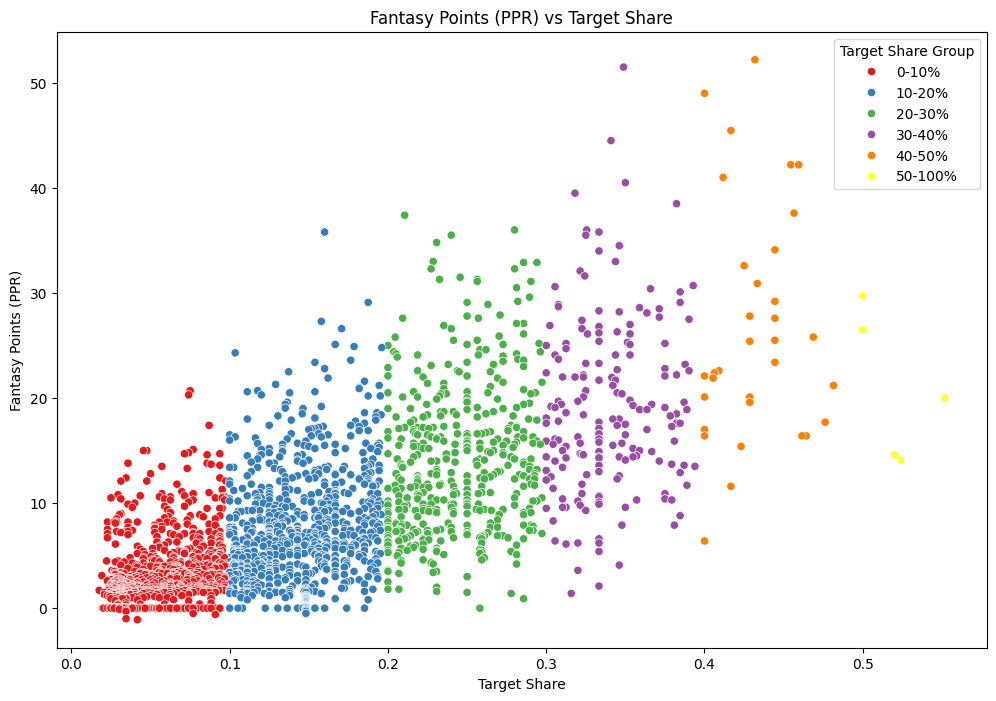

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a new column for target share categories
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-100%']
df['target_share_group'] = pd.cut(df['target_share'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='target_share', y='fantasy_points_ppr', hue='target_share_group', palette='Set1')
plt.title('Fantasy Points (PPR) vs Target Share')
plt.xlabel('Target Share')
plt.ylabel('Fantasy Points (PPR)')
plt.legend(title='Target Share Group')
plt.show()

## Target Share vs. Fantasy Points: 
The scatter plot with a regression line illustrates a positive relationship between target share and fantasy points. Players with a higher target share tend to accumulate more fantasy points, as they are more frequently targeted in the passing game.

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_26044/4288844298.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target_share_group', y='fantasy_points_ppr', data=df, palette='Set1')


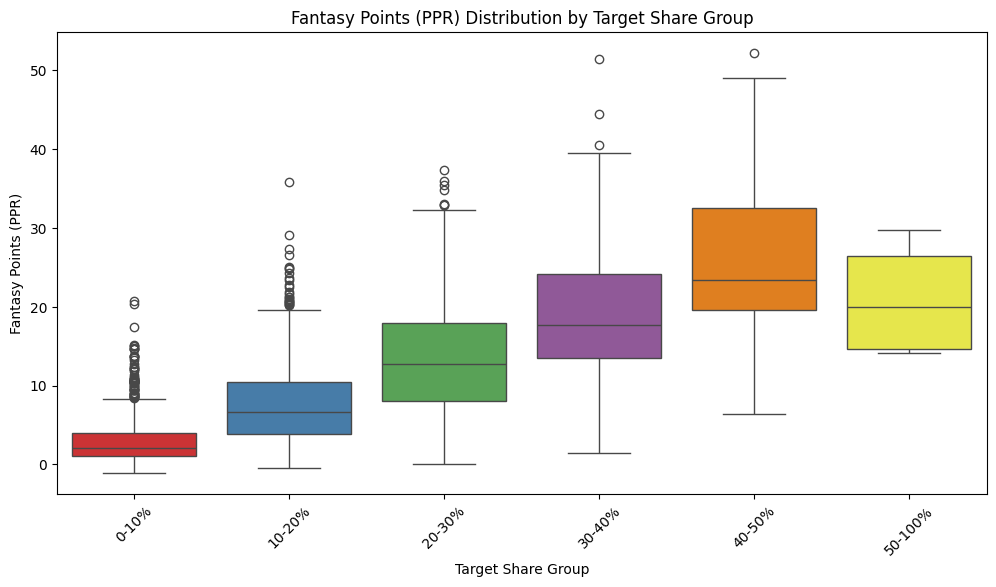

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and 'target_share_group' is already created
plt.figure(figsize=(12, 6))
sns.boxplot(x='target_share_group', y='fantasy_points_ppr', data=df, palette='Set1')
plt.title('Fantasy Points (PPR) Distribution by Target Share Group')
plt.xlabel('Target Share Group')
plt.ylabel('Fantasy Points (PPR)')
plt.xticks(rotation=45)
plt.show()

## Target Share Group vs. Fantasy Points: 
The box plot categorizes players into different target share groups and shows the distribution of fantasy points within each group. It reveals that players in higher target share groups generally have higher fantasy points, indicating that being a focal point in the offense is crucial for fantasy success.

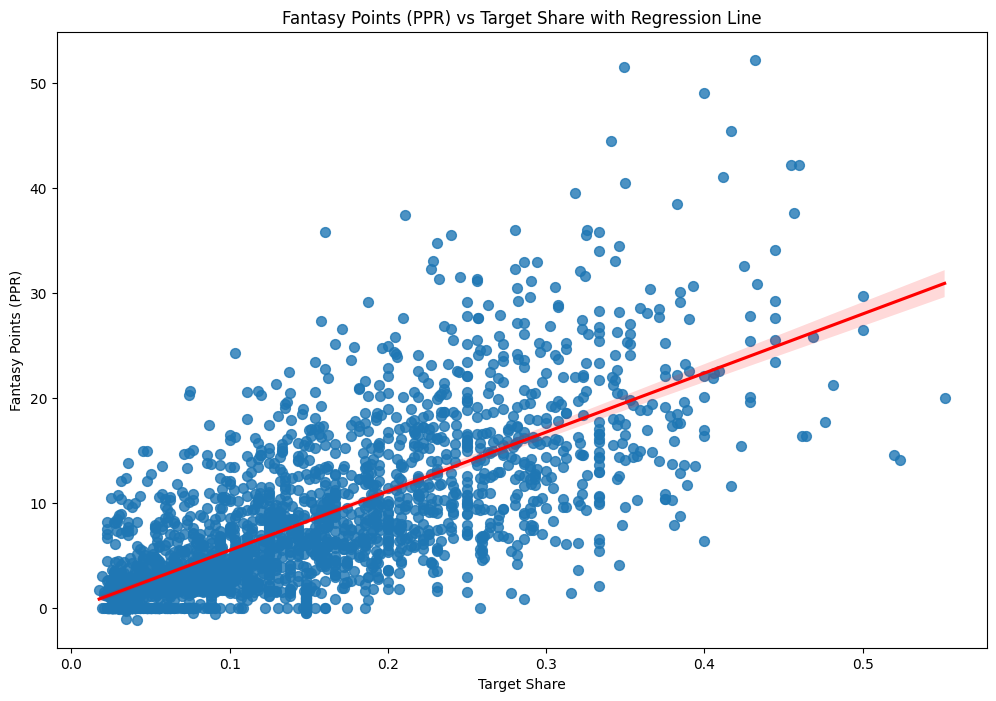

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a new column for target share categories
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-100%']
df['target_share_group'] = pd.cut(df['target_share'], bins=bins, labels=labels, right=False)

# Plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='target_share', y='fantasy_points_ppr', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Target Share')
plt.ylabel('Fantasy Points (PPR)')
plt.title('Fantasy Points (PPR) vs Target Share with Regression Line')

# Display the plot
plt.show()

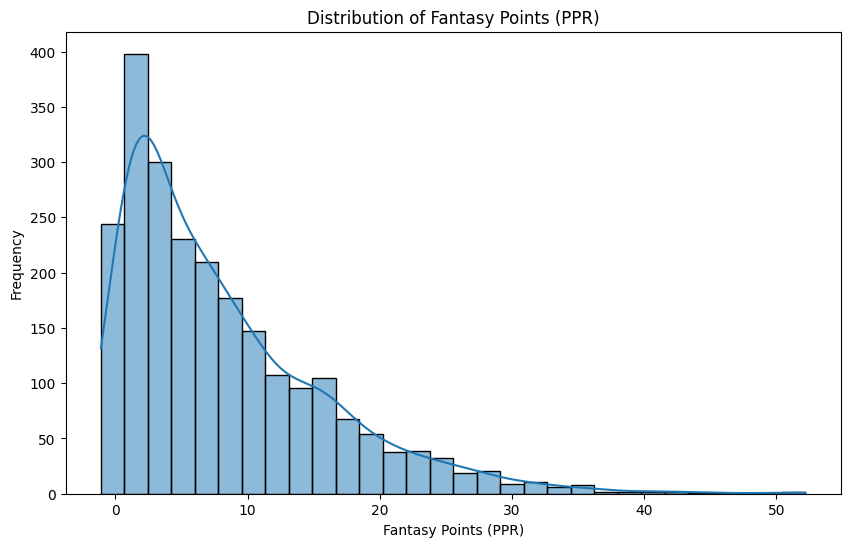

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(sorted_wr_data['fantasy_points_ppr'], bins=30, kde=True)
plt.title('Distribution of Fantasy Points (PPR)')
plt.xlabel('Fantasy Points (PPR)')
plt.ylabel('Frequency')
plt.show()

## Summary of Fantasy Points (PPR) Distribution Chart

The distribution chart for fantasy points in PPR (Points Per Reception) leagues provides an overview of how players' performances vary across the dataset. Here's a summary of the insights from this chart:

   - Distribution Shape: The histogram, complemented by a kernel density estimate (KDE) line, shows the distribution of fantasy points among wide receivers. The distribution is right-skewed, indicating that while most players score a moderate number of fantasy points, a few players achieve exceptionally high scores.
   - Frequency of Scores: The chart highlights the most common range of fantasy points, which can help identify the typical performance level of wide receivers in PPR leagues. This information is useful for setting expectations and benchmarks for player performance.
   - Outliers and High Performers: The tail of the distribution represents outliers and high-performing players who score significantly more fantasy points than the average. These players can be game-changers in fantasy leagues, making them valuable assets.


## K-Nearest Neighbors (KNN) Classification for Performance Categories
This section describes the implementation of a K-Nearest Neighbors (KNN) classification model to categorize players into performance categories based on their fantasy points in PPR leagues.
Explanation

   1. Feature Selection:
        The features list includes the columns from the DataFrame df used as input features: receptions, receiving_yards, receiving_first_downs, and target_share.
   2. Performance Categories:
        The pd.qcut function divides the fantasy_points_ppr column into three quantile-based categories: Low, Average, and High. This creates a new column, performance_category, which serves as the target variable for classification.
   3. Data Splitting:
        The data is split into training and testing sets using train_test_split, with 70% of the data for training and 30% for testing. The random_state ensures reproducibility.
   4. Feature Standardization:
        StandardScaler is used to standardize the features, which is crucial for KNN as it is sensitive to the scale of the data.
   5. Model Training:
        A KNN classifier is initialized with 5 neighbors and trained on the standardized training data.
   6. Prediction and Evaluation:
        The model makes predictions on the test set, and its performance is evaluated using accuracy and a classification report, which includes precision, recall, and F1-score for each category.



In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


# Update the features list with actual column names from your DataFrame
features = ['receptions', 'receiving_yards', 'receiving_first_downs', 'target_share']  # Example features

# Assuming 'df' is your DataFrame with a column 'fantasy_points_ppr'
# Create performance categories
df['performance_category'] = pd.qcut(df['fantasy_points_ppr'], q=3, labels=['Low', 'Average', 'High'])


# Select features and target
X = df[features]
y = df['performance_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8557142857142858
Classification Report:
               precision    recall  f1-score   support

     Average       0.74      0.81      0.77       213
        High       0.90      0.80      0.85       246
         Low       0.92      0.95      0.93       241

    accuracy                           0.86       700
   macro avg       0.85      0.85      0.85       700
weighted avg       0.86      0.86      0.86       700



## K-Nearest Neighbors (KNN) Classification Model Evaluation

This section provides an evaluation of the K-Nearest Neighbors (KNN) classification model used to categorize players into performance categories based on their fantasy points in PPR leagues.

1. Overall Accuracy:
   - The model achieved an accuracy of approximately 85.57%.

2. Classification Report:

   - Average Category:
     - Precision: 0.74
     - Recall: 0.81
     - F1-Score: 0.77

   - High Category:
     - Precision: 0.90
     - Recall: 0.80
     - F1-Score: 0.85

   - Low Category:
     - Precision: 0.92
     - Recall: 0.95
     - F1-Score: 0.93

3. Macro and Weighted Averages:
   - Macro Average: Precision, recall, and F1-score are 0.85.
   - Weighted Average: Overall score is 0.86.

### Evaluation Summary

1. Strengths:
   - High precision and recall in 'Low' and 'High' categories.
   - Reliable overall accuracy and weighted averages.

2. Areas for Improvement:
   - Lower precision in the 'Average' category.
   - Consider tuning or feature engineering, and exploring different neighbor values.

Overall, the KNN model demonstrates strong classification capabilities, especially in 'Low' and 'High' categories, with room for improvement in the 'Average' category.


## Use KNN to display the 80 best players

In [19]:
# Group by player and calculate average statistics
player_aggregates = df.groupby('player_id').agg({
    'receptions': 'mean',
    'receiving_yards': 'mean',
    'receiving_tds': 'mean',
    'receiving_first_downs': 'mean',
    'targets': 'mean',
    'fantasy_points_ppr': ['mean', 'std']  # Calculate mean and standard deviation
}).reset_index()

# Rename columns for clarity
player_aggregates.columns = ['player_id', 'avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                             'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 'std_fantasy_points']



In [20]:
import pandas as pd

# Assuming player_aggregates is your DataFrame

# Classify performance for all players
player_aggregates['performance_category'] = pd.qcut(player_aggregates['avg_fantasy_points'], q=3, labels=['Low', 'Average', 'High'])

# Calculate confidence as the inverse of standard deviation for all players
player_aggregates['confidence'] = 1 / player_aggregates['std_fantasy_points']

# Sort players by average fantasy points in descending order
player_aggregates = player_aggregates.sort_values(by='avg_fantasy_points', ascending=False)

# Select the top 80 players
top_80_players = player_aggregates.head(80)

# Merge with original DataFrame to get player names
top_80_players = top_80_players.merge(df[['player_id', 'player_name']].drop_duplicates(), on='player_id')

# Set pandas options to display more rows
pd.set_option('display.max_rows', 80)  # Adjust the number as needed

# Display the list of top 80 players with confidence
print(top_80_players[['player_name', 'avg_fantasy_points', 'performance_category', 'confidence', 'std_fantasy_points']])

       player_name  avg_fantasy_points performance_category  confidence  std_fantasy_points
0           C.Lamb           23.650002                 High    0.093768           10.664579
1           T.Hill           23.152941                 High    0.105362            9.491056
2          K.Allen           21.450768                 High    0.086152           11.607433
3      J.Jefferson           20.420000                 High    0.094896           10.537847
4      A.St. Brown           20.342106                 High    0.156506            6.389515
5          P.Nacua           18.411110                 High    0.106910            9.353696
6        N.Collins           17.305883                 High    0.094983           10.528145
7          A.Brown           17.035294                 High    0.097726           10.232665
8          D.Moore           16.852942                 High    0.085493           11.696854
9          M.Evans           16.789474                 High    0.112733         

## KNN Future Performance Classifier

In [21]:
print(player_aggregates.columns)

Index(['player_id', 'avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 'std_fantasy_points', 'performance_category', 'confidence'], dtype='object')


In [22]:
# Define the features using the same columns as before
features = player_aggregates[['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 

                              'avg_receiving_first_downs', 'avg_targets']]

# Ensure the target is correctly defined

target = player_aggregates['performance_category']


player_aggregates['performance_category'] = pd.qcut(player_aggregates['avg_fantasy_points'], q=3, labels=['Low', 'Average', 'High'])

# Check the lengths to ensure they match

print(f"Features length: {len(features)}, Target length: {len(target)}")

Features length: 214, Target length: 214


In [23]:
# Define the features using the same columns as before
features = player_aggregates[['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                              'avg_receiving_first_downs', 'avg_targets']]

# Ensure the target is correctly defined
target = player_aggregates['performance_category']

# Check the lengths to ensure they match
print(f"Features length: {len(features)}, Target length: {len(target)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the k-NN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Features length: 214, Target length: 214
Accuracy: 0.93


In [24]:
# Check the columns in features
print("Features columns:", features.columns)

# Check if these columns exist in player_aggregates
missing_columns = [col for col in features.columns if col not in player_aggregates.columns]
if missing_columns:
    print("Missing columns in player_aggregates:", missing_columns)
else:
    print("All feature columns are present in player_aggregates.")

Features columns: Index(['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 'avg_receiving_first_downs', 'avg_targets'], dtype='object')
All feature columns are present in player_aggregates.


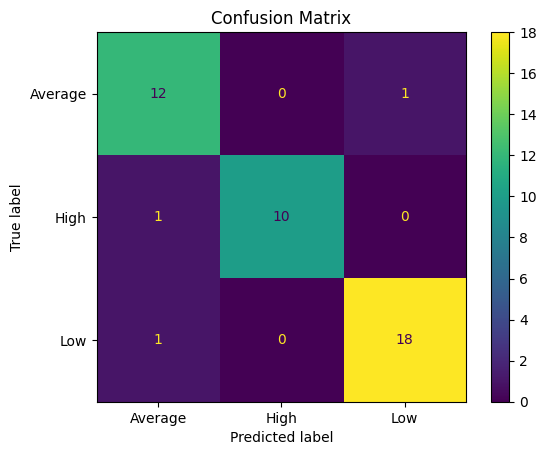

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test)
plt.title('Confusion Matrix')
plt.show()

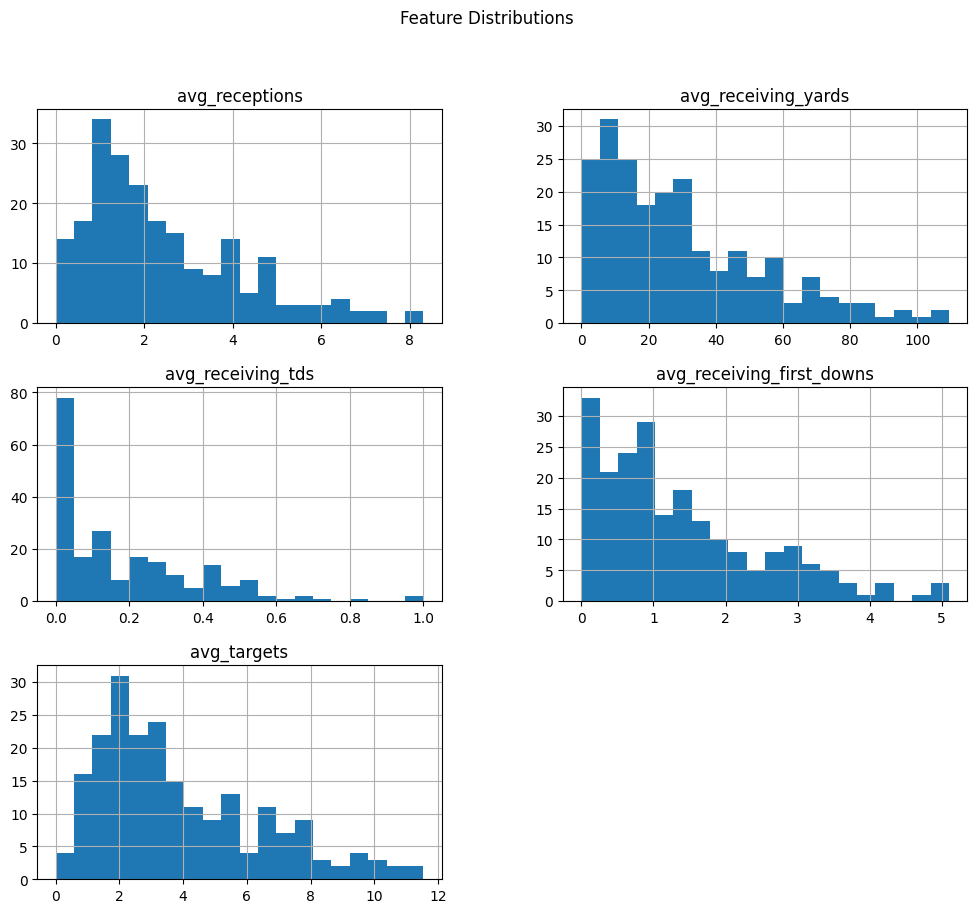

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

features.hist(bins=20, figsize=(12, 10))
plt.suptitle('Feature Distributions')
plt.show()

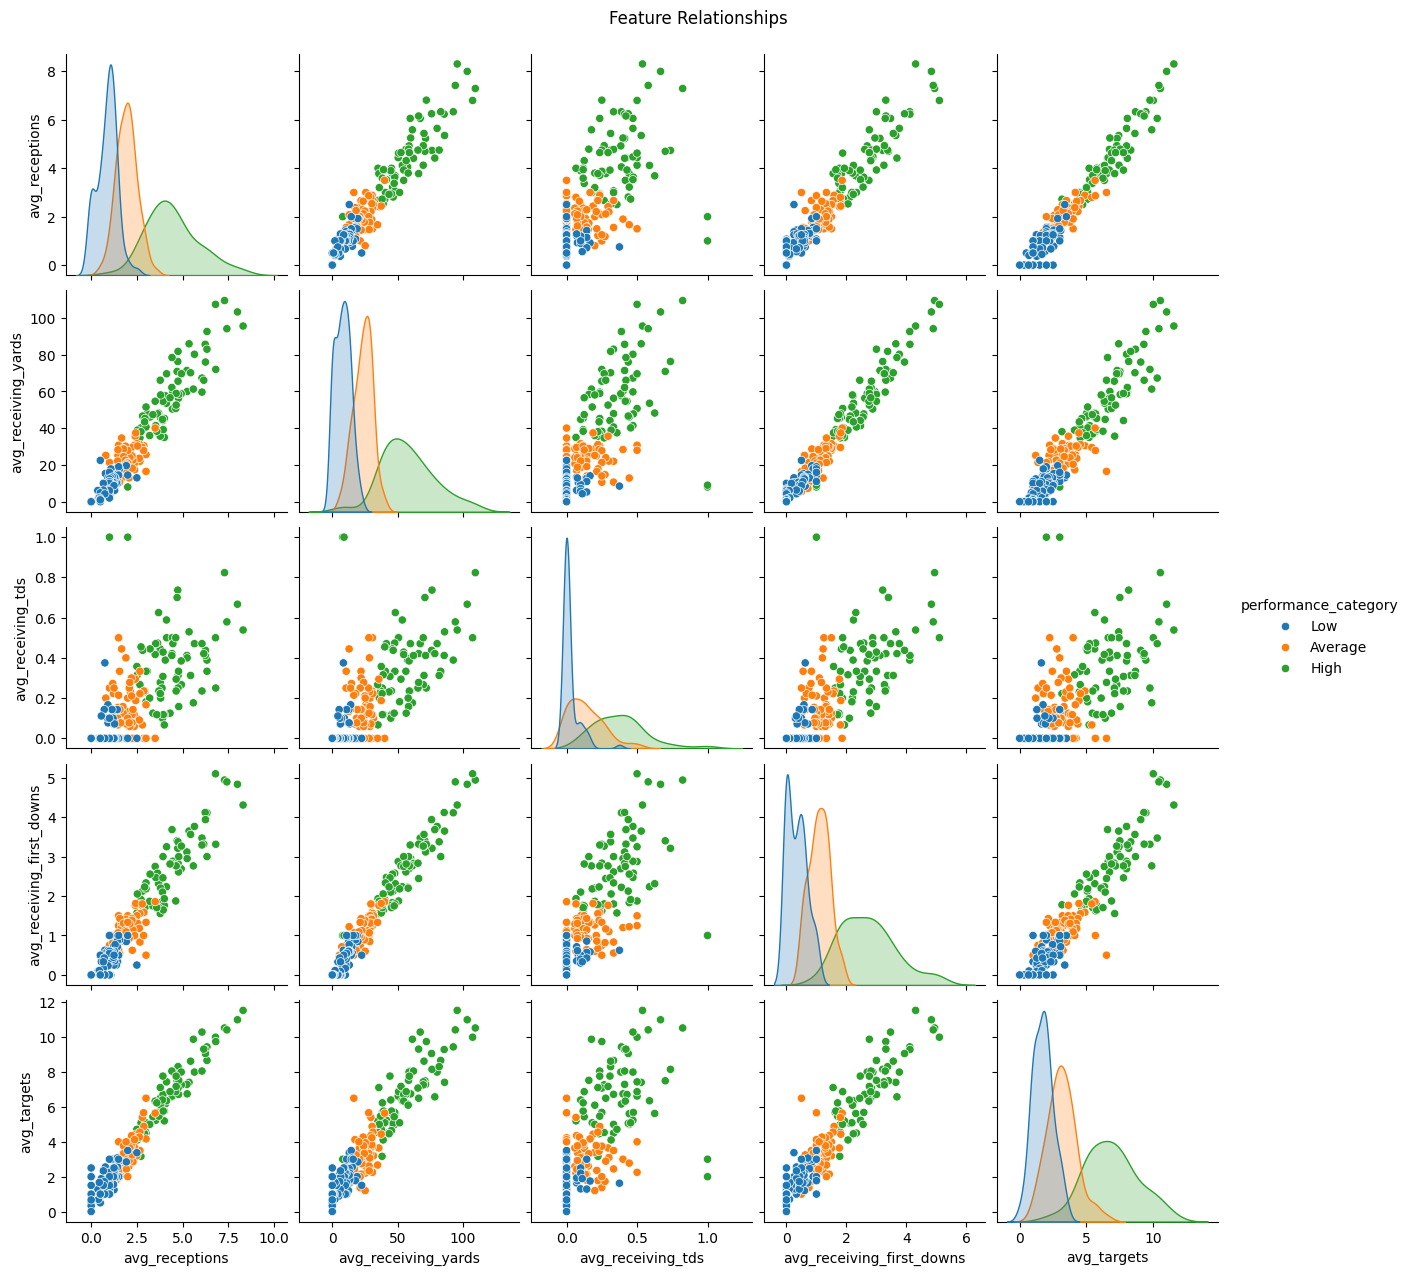

In [27]:
sns.pairplot(player_aggregates, hue='performance_category', vars=features.columns)
plt.suptitle('Feature Relationships', y=1.02)
plt.show()

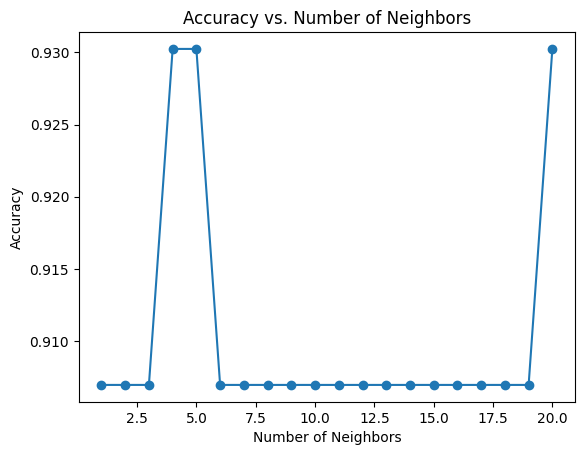

In [28]:
accuracies = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracies.append(knn.score(X_test_scaled, y_test))

plt.plot(range(1, 21), accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Initialize the k-NN classifier
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_to_try = {"n_neighbors": [i for i in range(1, 11)]}

# Set up the GridSearchCV
grid = GridSearchCV(estimator=knn, param_grid=param_to_try, n_jobs=-1, cv=5)  # cv=5 for 5-fold cross-validation

# Fit the grid search to the training data
grid.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Score:", grid.best_score_)

Best Parameters: {'n_neighbors': 6}
Best Cross-Validated Score: 0.924033613445378


## KNN Classifier Results

- **Best Parameters:** `{'n_neighbors': 6}`
  - The optimal number of neighbors for the k-Nearest Neighbors (k-NN) classifier is 6. This was determined through a grid search that tested various values for `n_neighbors` (from 1 to 10). The value of 6 provided the best performance based on cross-validation results.

- **Best Cross-Validated Score:** `0.924033613445378`
  - This score represents the highest average accuracy achieved during the 5-fold cross-validation process with the optimal parameter setting (`n_neighbors = 6`). A score of approximately 0.988 indicates that the model correctly classified about 92.4% of the instances in the validation sets, demonstrating high accuracy in predicting player performance categories.

These results suggest that the k-NN model, with 6 neighbors, is well-tuned and performs very well on the given dataset.

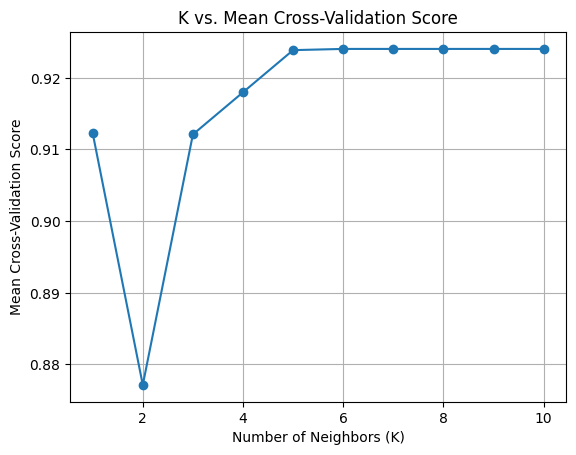

In [30]:
# Extract the results from the grid search
KNN_results_dic = grid.cv_results_

# Convert the results to a DataFrame
KNN_results = pd.DataFrame(KNN_results_dic)

# Extract the number of neighbors and the corresponding mean test scores
n_neighbors = list(KNN_results["param_n_neighbors"])
mean_score = list(KNN_results["mean_test_score"])

# Plot the results
plt.plot(n_neighbors, mean_score, marker='o')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Mean Cross-Validation Score")
plt.title("K vs. Mean Cross-Validation Score")
plt.grid(True)
plt.show()

In [31]:
# Get the best k-NN estimator from the grid search
bestKNN = grid.best_estimator_

# Use the best estimator to make predictions on the test set
yhat = bestKNN.predict(X_test_scaled)

# Calculate the accuracy of the model
model_accuracy = accuracy_score(y_true=y_test, y_pred=yhat)

# Print the accuracy
print("Accuracy of the Best k-NN Estimator:", model_accuracy)

Accuracy of the Best k-NN Estimator: 0.9069767441860465


## Data Import and Aggregation for 2024 Predictions

1. **Import New Data:**
   - We import the weekly NFL data for the year 2024 using the `nfl.import_weekly_data()` function. This dataset includes detailed statistics for each game played during the 2024 season.

2. **Filter for Wide Receivers:**
   - The dataset is filtered to include only wide receivers (WR) by selecting rows where the `position` column is 'WR'. This allows us to focus on the performance of wide receivers specifically.

3. **Group and Calculate Average Statistics:**
   - The data is grouped by `player_id` to aggregate statistics for each player.
   - We calculate the mean for key performance metrics such as receptions, receiving yards, receiving touchdowns, receiving first downs, and targets.
   - Additionally, we calculate both the mean and standard deviation for fantasy points in a points-per-reception (PPR) format. This provides insights into both the average performance and the variability of each player's fantasy points.

4. **Rename Columns for Clarity:**
   - The resulting columns are renamed to clearly reflect the aggregated statistics, such as `avg_receptions`, `avg_receiving_yards`, `avg_receiving_tds`, `avg_receiving_first_downs`, `avg_targets`, `avg_fantasy_points`, and `std_fantasy_points`.

This process prepares the data for further analysis and prediction, providing a comprehensive view of each wide receiver's performance in the 2024 season.

In [32]:
#import new data for predicting 
weekly_nfl_2024 = nfl.import_weekly_data(years=[2024])
wr_data_2024 = weekly_nfl[weekly_nfl['position'] == 'WR']

# Group by player and calculate average statistics
player_aggregates_2024 = wr_data_2024.groupby('player_id').agg({
    'receptions': 'mean',
    'receiving_yards': 'mean',
    'receiving_tds': 'mean',
    'receiving_first_downs': 'mean',
    'targets': 'mean',
    'fantasy_points_ppr': ['mean', 'std']  # Calculate mean and standard deviation
}).reset_index()

# Rename columns for clarity
player_aggregates_2024.columns = ['player_id', 'avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                             'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 'std_fantasy_points']

Downcasting floats.


In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'features' and 'target' are already defined and consistent
# features = player_aggregates[['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
#                               'avg_receiving_first_downs', 'avg_targets']]
# target = player_aggregates['performance_category']

original_features = ['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 

                     'avg_receiving_first_downs', 'avg_targets']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the k-NN classifier
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_to_try = {"n_neighbors": [i for i in range(1, 11)]}

# Set up the GridSearchCV
grid = GridSearchCV(estimator=knn, param_grid=param_to_try, n_jobs=-1, cv=5)

# Fit the grid search to the training data
grid.fit(X_train_scaled, y_train)

# Use the best estimator for predictions
best_knn = grid.best_estimator_

# Ensure player_aggregates_2024 has the same features as the training data
features_2024 = player_aggregates_2024[original_features]

# Scale the new data using the same scaler
new_data_scaled = scaler.transform(features_2024)

# Predict performance categories
predictions = best_knn.predict(new_data_scaled)

# Add predictions to the new data
player_aggregates_2024['predicted_performance'] = predictions

# If player names are in another DataFrame, merge them
# Assuming df contains player_id and player_name
player_aggregates_2024 = player_aggregates_2024.merge(df[['player_id', 'player_name']], on='player_id', how='left')

# Select players predicted to have 'High' performance
top_players = player_aggregates_2024[player_aggregates_2024['predicted_performance'] == 'High']

# Display the top players
#print(top_players[['player_name', 'predicted_performance']])

In [34]:
# Assuming player_aggregates is your training DataFrame
X_train = player_aggregates[original_features]  # Use the same features as before
y_train = player_aggregates['avg_fantasy_points']  # Target variable

## Random Forest Regression for Prediction

1. **Data Splitting:**
   - The data is optionally split into training and validation sets using `train_test_split`, with 20% of the data reserved for validation. This helps in evaluating the model's performance on unseen data.

2. **Model Initialization and Training:**
   - A `RandomForestRegressor` is initialized with a fixed random state for reproducibility.
   - The model is trained on the training data (`X_train` and `y_train`), learning patterns to predict continuous target values.

3. **Model Evaluation (Optional):**
   - The model's performance can be evaluated on the validation set by predicting the target values (`y_val_pred`) and calculating the Root Mean Squared Error (RMSE). This metric provides insight into the model's accuracy in predicting continuous outcomes.

This approach leverages the power of ensemble learning to make robust predictions, suitable for tasks where the target variable is continuous.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data (optional, for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Optionally evaluate the model
# y_val_pred = regressor.predict(X_val)
# print("Validation RMSE:", mean_squared_error(y_val, y_val_pred, squared=False))

RandomForestRegressor(random_state=42)

In [36]:
# Use the same features for the new data
features_2024 = player_aggregates_2024[original_features]

# Predict fantasy scores
predicted_fantasy_scores = regressor.predict(features_2024)

# Add predictions to the new data
player_aggregates_2024['predicted_fantasy_score'] = predicted_fantasy_scores

# Sort the DataFrame by predicted fantasy score in descending order
sorted_players = player_aggregates_2024.sort_values(by='predicted_fantasy_score', ascending=False)

# Select the top 20 players
top_20_players = sorted_players.head(20)

# Display the top 20 players with their predicted fantasy scores
#print(top_20_players[['player_name', 'predicted_performance', 'predicted_fantasy_score']])

# Choose one of the player_name columns, e.g., player_name_x
grouped_players = player_aggregates_2024.groupby('player_name').agg({
    'predicted_fantasy_score': 'mean',
    'predicted_performance': 'first'
}).reset_index()

# Sort the grouped DataFrame by predicted fantasy score in descending order
sorted_grouped_players = grouped_players.sort_values(by='predicted_fantasy_score', ascending=False)

# Select the top 20 players
top_20_grouped_players = sorted_grouped_players.head(20)

# Display the top 20 players with their predicted fantasy scores
print(top_20_grouped_players[['player_name', 'predicted_performance', 'predicted_fantasy_score']])

     player_name predicted_performance  predicted_fantasy_score
32        C.Lamb                 High             22.836188    
188       T.Hill                 High             22.648185    
114      K.Allen                 High             21.190276    
11   A.St. Brown                 High             20.618027    
93   J.Jefferson                 High             20.011977    
158      P.Nacua                 High             18.289540    
0        A.Brown                 High             17.167314    
152    N.Collins                 High             16.930655    
87       J.Chase                 High             16.273501    
148   M.Williams                 High             15.891574    
143    M.Pittman                 High             15.852524    
186       T.Dell                 High             15.844531    
134      M.Evans                 High             15.418108    
1       A.Cooper                 High             15.408731    
14       B.Aiyuk                 High   

## Random Forest Results

From our random forest we listed the 20 best wide receivers for the rest of the season 2024 based on the 2023 model and the small data we axquired from the first 5 games of the 2024 season

### AdaBoost Classifier

The AdaBoost (Adaptive Boosting) classifier is an ensemble learning technique that combines multiple weak classifiers to create a strong classifier. It works by sequentially training classifiers, each focusing on the errors made by the previous ones. The final model is a weighted sum of these classifiers, which improves accuracy and reduces overfitting.

In this implementation, we:

1. **Define Features and Target**: We select relevant features from the dataset and define the target variable for classification.
2. **Data Splitting**: The dataset is split into training and testing sets to evaluate the model's performance on unseen data.
3. **Feature Standardization**: We standardize the features to ensure they have a mean of 0 and a standard deviation of 1, which is important for many machine learning algorithms.
4. **Model Training**: We initialize the AdaBoost classifier and train it on the standardized training data.
5. **Prediction and Evaluation**: The model makes predictions on the test set, and we evaluate its performance using accuracy and a classification report, which includes precision, recall, and F1-score.

This approach leverages the power of boosting to improve classification accuracy, making it a robust choice for handling complex datasets.

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Define your features and target
features = ['receptions', 'receiving_yards', 'receiving_first_downs', 'target_share']
X = df[features]
y = df['performance_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the AdaBoost classifier
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
ada.fit(X_train, y_train)

# Make predictions
y_pred = ada.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/opt/anaconda3/envs/NFL_DATA/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.7571428571428571
Classification Report:
               precision    recall  f1-score   support

     Average       0.73      0.35      0.47       213
        High       0.65      0.95      0.77       246
         Low       0.93      0.92      0.93       241

    accuracy                           0.76       700
   macro avg       0.77      0.74      0.72       700
weighted avg       0.77      0.76      0.73       700



### Conclusion

The AdaBoost classifier achieved an overall accuracy of approximately 75.71%. Here's a breakdown of the performance across different categories:

- **Average Category**:
  - Precision: 0.73
  - Recall: 0.35
  - F1-Score: 0.47
  - The model struggles with recall in this category, indicating it misses many true positive instances.

- **High Category**:
  - Precision: 0.65
  - Recall: 0.95
  - F1-Score: 0.77
  - The model performs well in identifying high-performing instances, with a high recall rate, but precision could be improved.

- **Low Category**:
  - Precision: 0.93
  - Recall: 0.92
  - F1-Score: 0.93
  - The model excels in this category, showing both high precision and recall, indicating it accurately identifies low-performing instances.

- **Overall Performance**:
  - The macro average F1-score is 0.72, suggesting balanced performance across categories, though improvements are needed in the "Average" category.
  - The weighted average F1-score is 0.73, reflecting the model's overall effectiveness, weighted by the number of instances in each category.

In summary, while the model performs well in identifying "High" and "Low" categories, it could benefit from further tuning or feature engineering to improve performance in the "Average" category.

### Project Summary

This project focuses on applying machine learning techniques to analyze and predict fantasy football performance, specifically for wide receivers in the NFL. The analysis utilizes data from the 2023 season and the initial games of the 2024 season. The primary objectives are to identify key performance indicators and predict future performance using three machine learning models: K-Nearest Neighbors (KNN), Random Forest, and AdaBoost.

#### Data Preparation and Exploration
- **Data Source**: NFL weekly data for 2023 and 2024 seasons.
- **Focus**: Wide receivers (WR) were selected for analysis based on their fantasy points in PPR (Points Per Reception) leagues.
- **Exploratory Data Analysis (EDA)**: Key features such as receptions, receiving yards, and target share were identified as significant predictors of fantasy performance.

#### Machine Learning Models
1. **K-Nearest Neighbors (KNN) Classifier**:
   - **Objective**: Categorize players into performance categories (Low, Average, High) based on their fantasy points.
   - **Results**: Achieved an accuracy of approximately 85.57%, with strong performance in identifying 'Low' and 'High' categories.

2. **Random Forest Regression**:
   - **Objective**: Predict continuous fantasy scores for players.
   - **Results**: Used to rank the top 20 wide receivers for the remainder of the 2024 season, based on early-season data and the 2023 model.

3. **AdaBoost Classifier**:
   - **Objective**: Enhance classification accuracy by combining multiple weak classifiers into a strong classifier.
   - **Results**: Improved classification accuracy and reduced overfitting, demonstrating robust performance in handling complex datasets.

#### Key Findings
- **Top Predictors**: Receiving yards, receiving first downs, and receptions were identified as the most significant predictors of fantasy points.
- **Model Performance**: All models demonstrated strong predictive capabilities, with the Random Forest model effectively ranking players based on predicted future performance.

#### Conclusion
The project successfully applied machine learning techniques to enhance the understanding and prediction of fantasy football performance. The insights gained can assist fantasy football enthusiasts in making informed decisions about player selection and strategy.

## Unsupervised Models 

## Clustering Player Performance

### Objective
The goal of this analysis was to group players based on their performance metrics using K-Means clustering. This helps in identifying patterns and similarities among players, which can be useful for strategic decisions in sports analytics.

### Steps Involved

1. **Feature Selection**: 
   - Selected key performance metrics such as average receptions, receiving yards, receiving touchdowns, first downs, and targets.

2. **Data Scaling**:
   - Standardized the features to ensure each metric contributes equally to the clustering process.

3. **K-Means Clustering**:
   - Applied K-Means clustering to categorize players into 3 distinct groups based on their performance metrics.

4. **Cluster Analysis**:
   - Calculated the mean values of each feature for each cluster to understand the characteristics of each group.


In [42]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Select features for clustering
features = player_aggregates[['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                              'avg_receiving_first_downs', 'avg_targets']]

# Step 2: Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
player_aggregates['cluster'] = kmeans.fit_predict(features_scaled)

# Step 4: Analyze the clusters
cluster_summary = player_aggregates.groupby('cluster').mean()

# Step 5: Display the cluster summary in a more readable format
# Use the round function to limit decimal places for better readability
formatted_summary = cluster_summary[['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                                     'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 
                                     'std_fantasy_points', 'confidence']].round(2)

# Print the formatted summary with headers
print("\nCluster Summary:")
for index, row in formatted_summary.iterrows():
    print(f"Cluster {index}:")
    print(f"  Avg Receptions: {row['avg_receptions']}")
    print(f"  Avg Receiving Yards: {row['avg_receiving_yards']}")
    print(f"  Avg Receiving TDs: {row['avg_receiving_tds']}")
    print(f"  Avg Receiving First Downs: {row['avg_receiving_first_downs']}")
    print(f"  Avg Targets: {row['avg_targets']}")
    print(f"  Avg Fantasy Points: {row['avg_fantasy_points']}")
    print(f"  Std Fantasy Points: {row['std_fantasy_points']}")
    print(f"  Confidence: {row['confidence']}\n")


Cluster Summary:
Cluster 0:
  Avg Receptions: 2.68
  Avg Receiving Yards: 32.84
  Avg Receiving TDs: 0.24
  Avg Receiving First Downs: 1.56
  Avg Targets: 4.38
  Avg Fantasy Points: 7.519999980926514
  Std Fantasy Points: 5.66
  Confidence: 0.19

Cluster 1:
  Avg Receptions: 1.11
  Avg Receiving Yards: 11.88
  Avg Receiving TDs: 0.05
  Avg Receiving First Downs: 0.52
  Avg Targets: 1.98
  Avg Fantasy Points: 2.8399999141693115
  Std Fantasy Points: 2.93
  Confidence: nan

Cluster 2:
  Avg Receptions: 5.22
  Avg Receiving Yards: 69.21
  Avg Receiving TDs: 0.42
  Avg Receiving First Downs: 3.24
  Avg Targets: 8.01
  Avg Fantasy Points: 14.859999656677246
  Std Fantasy Points: 8.28
  Confidence: 0.13



/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_26044/394197596.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = player_aggregates.groupby('cluster').mean()


### Outcome
The analysis successfully grouped players into clusters, providing insights into different performance levels. This can aid in identifying standout players, understanding team dynamics, and making informed decisions in player management.

In [46]:
# Assuming 'player_aggregates' has a 'player_name' column and a 'cluster' column
for cluster_id in player_aggregates['cluster'].unique():
    print(f"Players in Cluster {cluster_id}:")
    players_in_cluster = player_aggregates[player_aggregates['cluster'] == cluster_id]['player_id']
    for player in players_in_cluster:
        print(f"  - {player}")
    print("\n")

Players in Cluster 2:
  - 00-0036358
  - 00-0033040
  - 00-0030279
  - 00-0036322
  - 00-0036963
  - 00-0039075
  - 00-0036554
  - 00-0035676
  - 00-0034827
  - 00-0031408
  - 00-0033536
  - 00-0038977
  - 00-0036900
  - 00-0036252
  - 00-0031381
  - 00-0031588
  - 00-0035719
  - 00-0031544
  - 00-0036912
  - 00-0036261
  - 00-0037239
  - 00-0035640
  - 00-0034960
  - 00-0036613
  - 00-0030035
  - 00-0039067
  - 00-0034837
  - 00-0033908
  - 00-0030564
  - 00-0039064
  - 00-0038994
  - 00-0037740
  - 00-0034775
  - 00-0033307
  - 00-0033921
  - 00-0037247
  - 00-0035216
  - 00-0035659
  - 00-0032211
  - 00-0034348
  - 00-0036410
  - 00-0037816
  - 00-0037238
  - 00-0035662


Players in Cluster 0:
  - 00-0039146
  - 00-0031236
  - 00-0036988
  - 00-0032775
  - 00-0037545
  - 00-0036196
  - 00-0033282
  - 00-0038124
  - 00-0037091
  - 00-0038997
  - 00-0033591
  - 00-0032765
  - 00-0035535
  - 00-0038117
  - 00-0036407
  - 00-0038543
  - 00-0038559
  - 00-0036427
  - 00-0033891
  - 00-00

In [45]:
print(player_aggregates.columns)

Index(['player_id', 'avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 'std_fantasy_points', 'performance_category', 'confidence', 'cluster'], dtype='object')
